In [52]:
from datetime import date, datetime, timedelta
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [53]:
# load cleaned and prepared data in EDA
df = pd.read_csv("zonePickupsFinal.csv", index_col="time_bin", parse_dates=["time_bin"])

In [54]:
def catOnlyDf(data):
    colList = data.columns.tolist()
    for col in range(len(colList)):
        try:
            colList[col] = int(colList[col])
        except:
            pass
        
    catFeatures = [str(col) for col in colList if type(col) != int]
    
    return data[catFeatures]

def numOnlyDf(data):
    colList = data.columns.tolist()
    for col in range(len(colList)):
        try:
            colList[col] = int(colList[col])
        except:
            pass
        
    numFeatures = [str(col) for col in colList if type(col) == int]
    
    return data[numFeatures]

In [55]:
catDf = catOnlyDf(df)

In [56]:
df = df[["237"]].join(catDf)

In [6]:
df1Num = numOnlyDf(df1["2019"])

## Predictions:
* year: 2019
* week ahead forecasts from Monday till Sunday
* error metric is computed for each week and averaged over all weeks
* pick one zone (237) forecasted (for now)

In [7]:
# divide df in weekly slices
start = datetime(2019,1,1,0,0)
end = datetime(2019,12,31,0,0)

In [8]:
slices = list()
startWeek = start
endWeek = start
while endWeek < end:
    endWeek = min(startWeek + timedelta(days=6-startWeek.weekday()), 
                  end)
    slices.append([startWeek.strftime("%Y-%m-%d"), 
                   endWeek.strftime("%Y-%m-%d")])
    startWeek = endWeek + timedelta(days=1)

In [10]:
df1Num[slices[0][0]:slices[0][1]].head(2)

,237,79,4
time_bin,,,
2019-01-01 00:00:00,214.0,268.0,16.0
2019-01-01 00:30:00,304.0,389.0,33.0


In [12]:
slices[:5]

[['2019-01-01', '2019-01-06'],
 ['2019-01-07', '2019-01-13'],
 ['2019-01-14', '2019-01-20'],
 ['2019-01-21', '2019-01-27'],
 ['2019-01-28', '2019-02-03']]

In [24]:
def plotWeekly(data, dataPred):
    plotSize = len(data.columns) * 3
    plt.figure(figsize=(7, plotSize))
    predErorrs = list()
    for i in range(len(data.columns)):
        myList = list()
        # create subplot
        plt.subplot(len(data.columns), 1, i+1)
        # get variable name
        name = data.columns[i]
        namePred = dataPred.columns[i]
        # plot data
        t = data.index.strftime("%Y-%m-%d %H:%M")
        plt.plot(t, np.array(data[name]), "b-", 
                 t, np.array(dataPred[namePred]), "r-")
        # error metric MAE
        mae = mean_absolute_error(np.array(data[name]),
                                  np.array(dataPred[namePred]))
        # set title
        myTitle = "MAE: " + str(int(mae)) + "  "\
                  + zones.loc[name,"Borough"]\
                  + ", "\
                  + zones.loc[name,"Zone"]\
                  + " "\
                  + data.index[0].strftime("%Y-%m-%d")\
                  + " - "\
                  + data.index[-1].strftime("%Y-%m-%d")
        plt.title(myTitle , y=1)
        # turn off ticks to remove clutter
        #pyplot.yticks([])
        plt.xticks([])
    plt.show()

In [25]:
# zones lookup table for Borough and Zone name against ID
zones = pd.read_csv('taxiZoneLookup.csv', index_col="LocationID")
zones.index = zones.index.astype(str)

In [65]:
# build base prediction: 
# take last week's value at the same time
#allMetrics = [0] * len(yAll.columns)
allMetrics = list()
for slice in slices:
    sliceMetrics = list()
    yAll = df1Num[slice[0]:slice[1]]
    yPredAll = df.loc[yAll.index - timedelta(days=7), yAll.columns.tolist()]
    for zone in yAll.columns:
        mae = mean_absolute_error(np.array(yAll[zone]), 
                                  np.array(yPredAll[zone]))
        sliceMetrics.append(mae)
    allMetrics.append(sliceMetrics)    
    #allMetrics = [sum(x) for x in zip(allMetrics, sliceMetrics)]

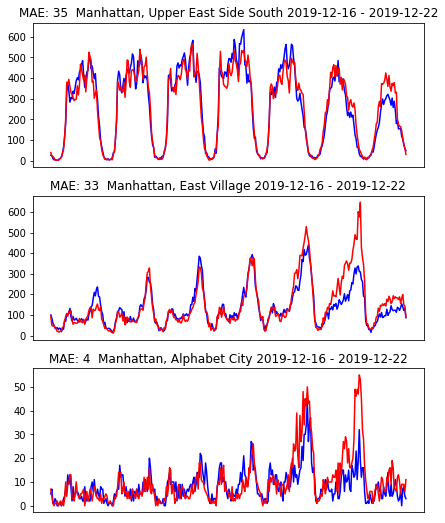

In [27]:
plotWeekly(yAll, yPredAll)

In [71]:
newSlices = list()
for slice in slices:
    newSlices.append(slice[0] + "-" + slice[1])

In [76]:
metricOverview = pd.DataFrame(allMetrics, index=newSlices, columns=yAll.columns)
for col in metricOverview.columns:
    metricOverview[col] = round(metricOverview[col],1)

In [78]:
metricOverview.mean()

237    37.767925
79     25.073585
4       3.630189
dtype: float64

# Multi-step Forecasts

In [96]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 

import xgboost as xgb # note for installation use py-xgboost in conda

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel

## SVR without autoregressive features

In [84]:
# zone 237 without weather data
df2 = df[["237"]].join(catDf)
df2 = df2[["237", "year", "hour", "weekday", "holiday"]]

In [93]:
def plotMonths(data, year, zone):
    # plot active power for each year
    months = [x for x in range(1, 13)]
    plt.figure(figsize=(8,10))
    for i in range(len(months)):
        # prepare subplot
        ax = plt.subplot(len(months), 1, i+1)
        # determine the month to plot
        month = str(year) + "-" + str(months[i])
        # get all observations for the month
        result = data[month]
        # plot the active power for the month
        plt.plot(result[zone])
        # add a title to the subplot
        plt.title(month, y=0, loc="left")
        # turn off ticks to remove clutter
        plt.yticks([])
        plt.xticks([])
    plt.show()

In [95]:
# plotMonths(df2, 2017, "237")

In [108]:
# resample data to daily
hourly = df2.resample("H")
hourlyDf = hourly.sum()

In [111]:
hourlyDf[["year", "hour", "weekday", "holiday"]] = hourlyDf[["year", "hour", "weekday", "holiday"]] / 2

In [114]:
# Define predictors and target variable
X = hourlyDf.drop("237", axis=1)
y = hourlyDf["237"]
print(X.shape)
print(y.shape)

(26280, 4)
(26280,)


In [119]:
# Split into train and test set 
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=1/3, shuffle=False)

In [121]:
print('X_train shape:', xTrain.shape)
print('X_test shape:', xTest.shape)
print('y_train shape:', yTrain.shape)
print('y_test shape:', yTest.shape)

X_train shape: (17520, 4)
X_test shape: (8760, 4)
y_train shape: (17520,)
y_test shape: (8760,)


In [134]:
from sklearn.pipeline import Pipeline

# Pipline for numerical features
numPipeline = Pipeline([
    ('imputerNum', SimpleImputer(strategy='median')),
    ('stdScaler', StandardScaler())
])

# Pipeline for categorical features 
catPipeline = Pipeline([
    ('imputerCat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [135]:
from sklearn.compose import ColumnTransformer

# Creating list for categorical predictors/features 
catFeatures = list(hourlyDf.columns[hourlyDf.dtypes==object])
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
numFeatures = list(hourlyDf.columns[hourlyDf.dtypes!=object])
numFeatures.remove("237")

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', numPipeline, numFeatures),
    ('cat', catPipeline, catFeatures)
])

In [212]:
from sklearn.svm import SVR

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipeSvr = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(C=10000, epsilon=0.01))
])

In [213]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

# Making predictions on the training set using cross validation as well as calculating the probabilities 
yTrainPred = cross_val_predict(pipeSvr, xTrain, yTrain, cv=5)

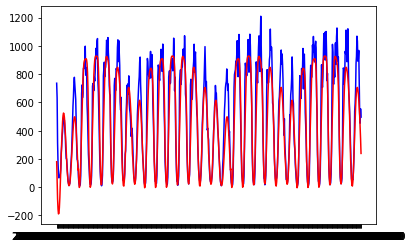

In [214]:
t = hourlyDf["2017":"2018"].index.strftime("%Y-%m-%d %H:%M")
plt.plot(t[:7*24*4], np.array(yTrain[:7*24*4]), "b-", 
         t[:7*24*4], np.array(yTrainPred[:7*24*4]), "r-")

In [197]:
mean_absolute_error(np.array(yTrain), np.array(yTrainPred))

102.0823111513186

In [217]:
from sklearn.metrics import mean_squared_error

# Defining parameter space for grid-search. Since we want to access the classifier step in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
paramSvr = {'svr__C': [1000, 2000, 5000, 7500, 10000],
            'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
            'svr__gamma': ("scale", "auto")
           }

gridSvr = GridSearchCV(pipeSvr, param_grid=paramSvr, cv=3, 
                           scoring='neg_mean_absolute_error', 
                           verbose=5, n_jobs=-1)

In [218]:
gridSvr.fit(xTrain, yTrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputerNum',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                 

In [219]:
# Show best parameters
print('Best score:\n{:.2f}'.format(gridSvr.best_score_))
print("Best parameters:\n{}".format(gridSvr.best_params_))

Best score:
-101.74
Best parameters:
{'svr__C': 10000, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}


## Add autogressive features (lags)

In [225]:
df = df2.copy()

In [231]:
df = df.rename(columns={"237": "rides"})

In [268]:
df.tail()

,rides,year,hour,weekday,holiday,date,lag1,lag2,lag3,lag4,lag5,lag_D1,lag_W1,mean_D1
time_bin,,,,,,,,,,,,,,
2019-12-31 21:30:00,162.0,2019,21,1,0,2019-12-31,203.0,228.0,254.0,185.0,169.0,111.0,177.0,146.0
2019-12-31 22:00:00,114.0,2019,22,1,0,2019-12-31,162.0,203.0,228.0,254.0,185.0,98.0,172.0,146.0
2019-12-31 22:30:00,143.0,2019,22,1,0,2019-12-31,114.0,162.0,203.0,228.0,254.0,90.0,165.0,146.0
2019-12-31 23:00:00,181.0,2019,23,1,0,2019-12-31,143.0,114.0,162.0,203.0,228.0,62.0,110.0,146.0
2019-12-31 23:30:00,100.0,2019,23,1,0,2019-12-31,181.0,143.0,114.0,162.0,203.0,45.0,96.0,146.0


In [265]:
df["date"] = df.index.date

start = date(2017,1,1)
entriesPerDay = 48

# last x entries
lags = 5
for i in range(1, lags+1):
    label = 'lag' + str(i)
    df[label] = df.rides.shift(i)

# last day's rides    
df['lag_D1'] = df.rides.shift(48)
# last week's rides
df['lag_W1'] = df.rides.shift(7*48)

# last day's average rides
df['mean_D1'] = df.date - timedelta(days=1)
avgRides = df.groupby("date").mean()['rides'].round()
df['mean_D1'] = df['mean_D1'].apply(lambda x: avgRides[x] if x >= start else float("NaN"))

In [270]:
# Define predictors and target variable
X = df.drop("rides", axis=1)
y = df["rides"]
print(X.shape)
print(y.shape)

# Split into train and test set 
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=1/3, random_state=42, shuffle=False)

(52560, 13)
(52560,)


In [271]:
# Creating list for categorical predictors/features 
catFeatures = list(df.columns[df.dtypes==object])
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
numFeatures = list(df.columns[df.dtypes!=object])
numFeatures.remove("rides")

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', numPipeline, numFeatures),
    ('cat', catPipeline, catFeatures)
])

In [272]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipeSvr = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(C=10000, epsilon=0.01))
])

In [273]:
# Making predictions on the training set using cross validation as well as calculating the probabilities 
yTrainPred = cross_val_predict(pipeSvr, xTrain, yTrain, cv=5)

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

In [277]:
mean_absolute_error(np.array(yTrain), np.array(yTrainPred))

23.982341320168302

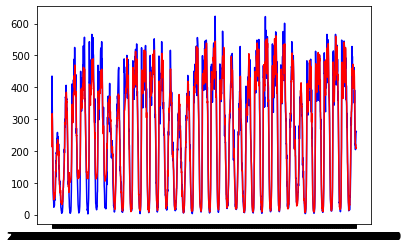

In [278]:
t = df["2017":"2018"].index.strftime("%Y-%m-%d %H:%M")
plt.plot(t[:7*24*10], np.array(yTrain[:7*24*10]), "b-", 
         t[:7*24*10], np.array(yTrainPred[:7*24*10]), "r-")

In [279]:
# Defining parameter space for grid-search. Since we want to access the classifier step in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
paramSvr = {'svr__C': [1000, 2000, 5000, 7500, 10000],
            'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
            'svr__gamma': ("scale", "auto")
           }

gridSvr = GridSearchCV(pipeSvr, param_grid=paramSvr, cv=3, 
                           scoring='neg_mean_absolute_error', 
                           verbose=5, n_jobs=-1)

In [ ]:
gridSvr.fit(xTrain, yTrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.1min


In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(gridSvr.best_score_))
print("Best parameters:\n{}".format(gridSvr.best_params_))

## LSTM for multi-step forecasting

In [220]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


# split a univariate dataset into train/test sets
def split_dataset(data):
    splitRatio = int(2*len(data)/3)
    # split into standard weeks
    train, test = data[:splitRatio], data[splitRatio:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/24))
    test = array(split(test, len(test)/24))
    return train, test


# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
    
    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=24):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)


# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 10, 50
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat


# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

In [221]:
train, test = split_dataset(hourlyDf.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(730, 24, 12)
736.0 259.0
(365, 24, 12)
518.0 281.0


In [222]:
#for i in [5,10,15,20]:
# split into train and test
train, test = split_dataset(hourlyDf.values)
# evaluate model and get scores
n_input, epochs, batch_size = 5, 10, 5
score, scores, pred = evaluate_model(train, test, n_input)
# summarize scores
#summarize_scores('lstm', score, scores)
# plot scores
# days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#hours = list(range(24))
#pyplot.plot(hours, scores, marker='o', label='lstm')
print("n inputs: " + str(10) + " => " + str(score))
#pyplot.show()

Epoch 1/10
350/350 [==============================] - 23s 67ms/step - loss: 2952065.0000
Epoch 2/10
350/350 [==============================] - 22s 63ms/step - loss: 187101.7969
Epoch 3/10
350/350 [==============================] - 22s 63ms/step - loss: 101132.9453
Epoch 4/10
350/350 [==============================] - 23s 66ms/step - loss: 465829.0938
Epoch 5/10
350/350 [==============================] - 23s 67ms/step - loss: 129271.5078
Epoch 6/10
350/350 [==============================] - 26s 76ms/step - loss: 85333.1875
Epoch 7/10
350/350 [==============================] - 23s 66ms/step - loss: 238293.5000
Epoch 8/10
350/350 [==============================] - 24s 69ms/step - loss: 142238.5000
Epoch 9/10
350/350 [==============================] - 25s 70ms/step - loss: 102723.8594
Epoch 10/10
350/350 [==============================] - 24s 68ms/step - loss: 75740.0000
n inputs: 10 => 204.31653406846448


In [ ]:
# n inputs: 5 => 175.68729989316245
# n inputs: 10 => 137.0711921548434
# n inputs: 15 => 133.48263288252147
# n inputs: 20 => 189.59650824184502
# n inputs: 30 => 147.48559251669298

In [135]:
# resample data to daily
resampled = df.resample("H")
resampledDf = resampled.sum()
noTarget = resampledDf.drop("237", axis=1) / 2

In [94]:
target = resampledDf["237"]

In [101]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
noTarget = pd.DataFrame(scaler.fit_transform(noTarget), index=noTarget.index, columns=noTarget.columns)

In [119]:
hourlyDf = pd.DataFrame(target).join(noTarget)

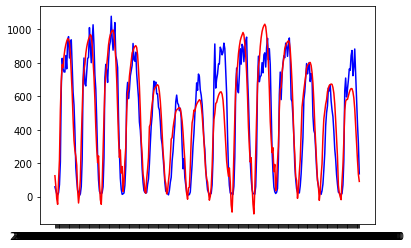

In [196]:
t = hourlyDf["2019"].index.strftime("%Y-%m-%d %H:%M")
plt.plot(t[24*14:24*28], yTestList[24*14:24*28], "b-", 
         t[24*14:24*28], yPredList[24*14:24*28], "r-")

In [153]:
t = hourlyDf["2019"].index.strftime("%Y-%m-%d %H:%M")

In [192]:
yPredList = [item for sublist in pred.tolist() for item in sublist]

In [193]:
yTestList = [item for sublist in test[:, :, 0].tolist() for item in sublist]